In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(style='darkgrid')

Ladataan liigadata, joka sisältää SM-liigan runkosarjan otteluiden lopputulokset viimeiseltä kymmeneltä kaudelta. 
Data on koottu excelin query-toiminnon avulla Liigan sivuilta, esim. http://liiga.fi/fi/ottelut/2018-2019/runkosarja/
Yleisömäärät olivat saatavilla vain kaudesta 2014-2015 eteenpäin

In [46]:
df = pd.read_excel('liiga_10_kautta.xlsx')

In [47]:
df.head()

,Peli,Pvm,Aika,Kotijoukkue,Vierasjoukkue,Kotimaalit,Vierasmaalit,Tapa,Yleisöä
0,1,2008-09-11,18:30:00,HIFK,Jokerit,5,3,N,-
1,2,2008-09-11,18:30:00,Ilves,Tappara,5,4,N,-
2,3,2008-09-11,18:30:00,KalPa,JYP,1,3,N,-
3,4,2008-09-11,18:30:00,Kärpät,SaiPa,7,0,N,-
4,5,2008-09-11,18:30:00,Pelicans,Blues,1,4,N,-


# Peliaikatulos:
Luodaan sarake peliaikatuloksille, jotta voidaan myöhemmin tarkastella esimerkiksi yleisimpiä otteluiden päättymistuloksia varsinaisella peliajalla.

In [48]:
peliaikatulos = []
for i in range(0,4262):
    
    if df['Tapa'].iloc[i] =='N':
    
        peliaikatulos.append(str(df['Kotimaalit'].iloc[i]) + '-' + str(df['Vierasmaalit'].iloc[i]))
        
    else:
        
        if df['Kotimaalit'].iloc[i] > df['Vierasmaalit'].iloc[i]:
            
            peliaikatulos.append(str(df['Kotimaalit'].iloc[i]-1) + '-' + str(df['Vierasmaalit'].iloc[i]))
            
        elif df['Kotimaalit'].iloc[i] < df['Vierasmaalit'].iloc[i]:

            peliaikatulos.append(str(df['Kotimaalit'].iloc[i]) + '-' + str(df['Vierasmaalit'].iloc[i]-1))
            
df['Peliaikatulos'] = peliaikatulos

# Peliaikamaalit:
Luodaan sarake varsinaisella peliajalla tehdyille maaleille. Tämän avulla voidaan tarkastella esimerkiksi yli/alle 5.5 maalia per ottelu jakaumaa.

In [49]:
peliaikamaalit = []

for i in range(0,4262):
    
    if df.iloc[i].Tapa == 'N':
        peliaikamaalit.append(df.iloc[i].Kotimaalit + df.iloc[i].Vierasmaalit)
    
    else:
        peliaikamaalit.append(df.iloc[i].Kotimaalit + df.iloc[i].Vierasmaalit - 1)

df['Peliaikamaalit'] = peliaikamaalit

# Kausi:
Lisätään kausi-sarake, jotta voidaan verrata tuloksia eri kausien välillä. 

In [50]:
#Pelien määrä datasetissä = 4262
df.shape

(4262, 11)

In [51]:
kausi = []
kaudet = ['2008-2009','2009-2010','2010-2011','2011-2012','2012-2013',
          '2013-2014','2014-2015','2015-2016','2016-2017','2017-2018']
vuodet = ['2008','2009','2010','2011','2012',
          '2013','2014','2015','2016','2017','2018']


#Tiedetään, että runkosarja alkaa syyskuussa(9) ja loppuu maaliskuussa(3).

k=0
v=0
i=0
while i in range(0,4262):
        
    if df.Pvm[i] >= df[(df.Pvm.dt.year == int(vuodet[v])) & (df.Pvm.dt.month==9)].Pvm.min() and df.Pvm[i] <= df[(df.Pvm.dt.year == int(vuodet[v+1])) & (df.Pvm.dt.month==3)].Pvm.max():
            
        kausi.append(kaudet[k])
        i = i+1
        
    else:
        k = k+1
        v = v+1
        
df['Kausi'] = kausi

# Merkki:
Lisätään vedonlyönnistä tuttu 1X2-merkki sen mukaan, päättyikö ottelu tasan, voittiko kotijoukkue vai voittiko vierasjoukkue.

In [52]:
merkki = []

for i in range(0,4262):
    
    if (df.Kotimaalit.iloc[i] > df.Vierasmaalit.iloc[i]) and (df.Tapa.iloc[i]=='N'):
        merkki.append('1')
        
    elif (df.Kotimaalit.iloc[i] < df.Vierasmaalit.iloc[i]) and (df.Tapa.iloc[i]=='N'):
        merkki.append('2')
        
    else:
        merkki.append('X')

df['Merkki'] = merkki

# Pelasiko joukkue päivää aiemmin:
Lisätään kaksi saraketta; pelasiko kotijoukkue "eilen" ja pelasiko vierasjoukkue "eilen". Tämän tarkoituksena on tehdä mahdollisuus tarkastella joukkueita peräkkäisten pelipäivien osalta. Mikä on esimerkiksi väsymyksen vaikutus peräkkäisinä pelipäivinä?

In [53]:
#Pelasiko kotijoukkue "eilen"?

#Pelipäivien määrä = 1003 (len(df.Pvm.unique()))

#Lisätään datasetin alkuun ensimmäisen kierroksen pelien verran nollia, koska ennen ensimmäistä päivää 
#kotijoukkue ei ole voinut pelata

koti_pelasi_eilen = []
ensimmainen_kierros = len(df[df['Pvm'] == df['Pvm'].unique()[0]].Kotijoukkue.values)
koti_pelasi_eilen = koti_pelasi_eilen + [0]*ensimmainen_kierros


for i in range(0,1002):
    
    #Lasketaan pelien määrä tarkastelupäivinä
    pelien_maara_i_1 = len(df[df['Pvm'] == df['Pvm'].unique()[i+1]].Kotijoukkue.values)
    pelien_maara_i = len(df[df['Pvm'] == df['Pvm'].unique()[i]].Kotijoukkue.values)
    
    # Jos pelipäivät peräkkäiset, niin...
    if (df['Pvm'].unique()[i] - df['Pvm'].unique()[i+1]).astype('timedelta64[D]').astype(int) == -1:
    
        for p in list(range(0, pelien_maara_i_1)):
                #tarkastetaan, pelasiko kotijoukkue eilen kotona...
            if  (df[df['Pvm'] == df['Pvm'].unique()[i+1]].Kotijoukkue.values[p]) in (df[df['Pvm'] == df['Pvm'].unique()[i]].Kotijoukkue.values):
    
                koti_pelasi_eilen.append(1)
                #...tai vieraissa
            elif (df[df['Pvm'] == df['Pvm'].unique()[i+1]].Kotijoukkue.values[p]) in (df[df['Pvm'] == df['Pvm'].unique()[i]].Vierasjoukkue.values):
    
                koti_pelasi_eilen.append(1)
            
                #Jos ei pelannut, niin lisätään nollia
            else:

                koti_pelasi_eilen.append(0)

    # Mikäli päivät eivät olleet peräkkäiset, niin....
    elif (df['Pvm'].unique()[i] - df['Pvm'].unique()[i+1]).astype('timedelta64[D]').astype(int) != -1:
        
        koti_pelasi_eilen = koti_pelasi_eilen + [0]*pelien_maara_i_1

df['Koti_pelasi_eilen'] = koti_pelasi_eilen

In [54]:
#Sama tarkastelu vierasjoukkueille

vieras_pelasi_eilen = []
ensimmainen_kierros = len(df[df['Pvm'] == df['Pvm'].unique()[0]].Kotijoukkue.values)
vieras_pelasi_eilen = vieras_pelasi_eilen + [0]*ensimmainen_kierros

for i in range(0,1002):
    
    #Lasketaan pelien määrä tarkastelupäivinä
    pelien_maara_i_1 = len(df[df['Pvm'] == df['Pvm'].unique()[i+1]].Vierasjoukkue.values)
    pelien_maara_i = len(df[df['Pvm'] == df['Pvm'].unique()[i]].Vierasjoukkue.values)
    
    # Jos pelipäivät peräkkäiset, niin...
    if (df['Pvm'].unique()[i] - df['Pvm'].unique()[i+1]).astype('timedelta64[D]').astype(int) == -1:
        

        for p in list(range(0, pelien_maara_i_1)):
                #tarkastetaan, pelasiko vierasjoukkue eilen kotona...
            if  (df[df['Pvm'] == df['Pvm'].unique()[i+1]].Vierasjoukkue.values[p]) in (df[df['Pvm'] == df['Pvm'].unique()[i]].Kotijoukkue.values):
    
                vieras_pelasi_eilen.append(1)
                #...tai vieraissa
            elif (df[df['Pvm'] == df['Pvm'].unique()[i+1]].Vierasjoukkue.values[p]) in (df[df['Pvm'] == df['Pvm'].unique()[i]].Vierasjoukkue.values):
    
                vieras_pelasi_eilen.append(1)
            
                #Jos ei pelannut, niin lisätään nollia
            else:

                vieras_pelasi_eilen.append(0)
        
    # Mikäli päivät eivät olleet peräkkäiset, niin....
    elif (df['Pvm'].unique()[i] - df['Pvm'].unique()[i+1]).astype('timedelta64[D]').astype(int) != -1:
        
        vieras_pelasi_eilen = vieras_pelasi_eilen + [0]*pelien_maara_i_1
        
df['Vieras_pelasi_eilen'] = vieras_pelasi_eilen

In [67]:
#Lopullinen dataframe analyysejä varten:
df.head()

,Peli,Pvm,Aika,Kotijoukkue,Vierasjoukkue,Kotimaalit,Vierasmaalit,Tapa,Yleisöä,Peliaikatulos,Peliaikamaalit,Kausi,Merkki,Koti_pelasi_eilen,Vieras_pelasi_eilen
0,1,2008-09-11,18:30:00,HIFK,Jokerit,5,3,N,-,5-3,8,2008-2009,1,0,0
1,2,2008-09-11,18:30:00,Ilves,Tappara,5,4,N,-,5-4,9,2008-2009,1,0,0
2,3,2008-09-11,18:30:00,KalPa,JYP,1,3,N,-,1-3,4,2008-2009,2,0,0
3,4,2008-09-11,18:30:00,Kärpät,SaiPa,7,0,N,-,7-0,7,2008-2009,1,0,0
4,5,2008-09-11,18:30:00,Pelicans,Blues,1,4,N,-,1-4,5,2008-2009,2,0,0


# Analyysit

Yleisimmät kotivoittoon päättyneiden otteluiden tulokset viimeisen kymmenen kauden ajalta ja niiden osuus prosentteina kaikista kotivoittotuloksista

In [214]:
df[df.Merkki=='1'].Peliaikatulos.value_counts(normalize=True).head(5)

3-2    0.114990
4-2    0.094969
4-1    0.093943
2-1    0.092916
3-1    0.092402
Name: Peliaikatulos, dtype: float64

In [272]:
#Viisi yleisintä kotivoittoon päättyneistä pelituloksista kattaa 49% kaikista kotivoittotuloksista
df[df.Merkki=='1'].Peliaikatulos.value_counts(normalize=True).head(5).values.sum()

0.4892197125256673

Yleisimmät tasapeliin päättyneiden otteluiden tulokset viimeisen kymmenen kauden ajalta ja niiden osuus prosentteina kaikista tasapelituloksista

In [73]:
df[df.Merkki=='X'].Peliaikatulos.value_counts(normalize=True).head(5)

2-2    0.376890
1-1    0.241901
3-3    0.225702
4-4    0.074514
0-0    0.046436
Name: Peliaikatulos, dtype: float64

In [74]:
#Viisi yleisintä tasapelitulosta kattaa yli 96% kaikista tasapelituloksista
df[df.Merkki =='X'].Peliaikatulos.value_counts(normalize=True).head(5).values.sum()

0.9654427645788337

Yleisimmät vierasvoittoon päättyneiden otteluiden tulokset viimeisen kymmenen kauden ajalta ja niiden osuus prosentteina kaikista vierasvoittotuloksista

In [75]:
df[df.Merkki=='2'].Peliaikatulos.value_counts(normalize=True).head(5)

1-2    0.124640
2-3    0.120317
1-3    0.110951
1-4    0.103746
2-4    0.085735
Name: Peliaikatulos, dtype: float64

In [76]:
#Viisi yleisintä vierasvoittoon päättyneistä pelituloksista kattaa 54% kaikista vierasvoittotuloksista
df[df.Merkki=='2'].Peliaikatulos.value_counts(normalize=True).head(5).values.sum()

0.5453890489913544

Yleisimmät tulokset kaikkiaan viimeisen kymmenen kauden ajalta ja niiden osuus kaikista pelituloksista

In [143]:
df.Peliaikatulos.value_counts(normalize=False).head(5)

2-2    349
3-2    224
1-1    224
3-3    209
4-2    185
Name: Peliaikatulos, dtype: int64

In [144]:
#Kaikista pelituksista viisi yleisintä kattaa 28% tuloksista
df.Peliaikatulos.value_counts(normalize=True).head(5).values.sum()

0.27944626935710937

Peliajalla (ei jatkoaika) tehtyjen maalien määrät

In [82]:
#Maaleja alle 4.5 kappaletta
df[df.Peliaikamaalit < 4.5].shape[0] / df.shape[0]

0.43899577663068984

In [275]:
#Maaleja alle 5.5 kappaletta
df[df.Peliaikamaalit < 5.5].shape[0] / df.shape[0]

0.6198967620835288

Vedonlyönnin näkökulmat - 1X2

In [89]:
#1X2 prosenttiosuudet vuosittain
df.groupby('Kausi').Merkki.value_counts(normalize=True)

Kausi      Merkki
2008-2009  1         0.472906
           2         0.364532
           X         0.162562
2009-2010  1         0.463054
           2         0.354680
           X         0.182266
2010-2011  1         0.454762
           2         0.330952
           X         0.214286
2011-2012  1         0.454762
           2         0.340476
           X         0.204762
2012-2013  1         0.445238
           2         0.316667
           X         0.238095
2013-2014  1         0.485714
           2         0.319048
           X         0.195238
2014-2015  1         0.483333
           2         0.273810
           X         0.242857
2015-2016  1         0.444444
           2         0.326667
           X         0.228889
2016-2017  1         0.417778
           2         0.331111
           X         0.251111
2017-2018  1         0.453333
           2         0.302222
           X         0.244444
Name: Merkki, dtype: float64

[Text(0,0.5,'Tasapelien %osuus'), Text(0.5,0,'Kausi')]

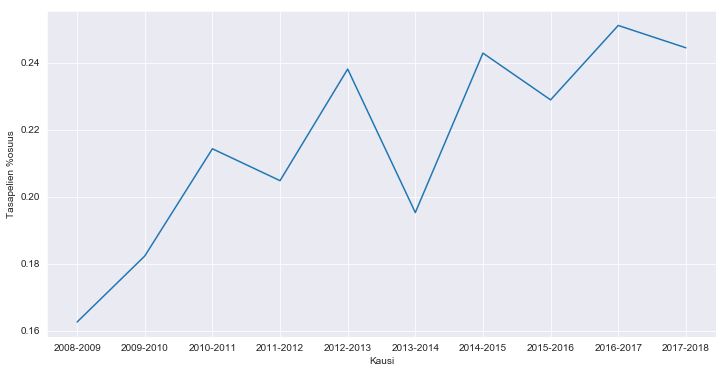

In [269]:
#Tarkastellaan tasapelien määrän kehitystä:
y = df.groupby('Kausi').Merkki.value_counts(normalize=True).values[2:30:3]

plt.figure(figsize=(12,6))
sns.lineplot(x=kaudet, y=y).set(xlabel='Kausi', ylabel='Tasapelien %osuus')

In [145]:
#Pelin päättyminen varsinaisella peliajalla (N), jatkoajalla(JA) tai voittolaukauskilpailussa (VL)
df.groupby('Kausi').Tapa.value_counts(normalize=True)

Kausi      Tapa
2008-2009  N       0.837438
           JA      0.086207
           VL      0.076355
2009-2010  N       0.817734
           JA      0.093596
           VL      0.088670
2010-2011  N       0.785714
           VL      0.128571
           JA      0.085714
2011-2012  N       0.795238
           VL      0.109524
           JA      0.095238
2012-2013  N       0.761905
           VL      0.147619
           JA      0.090476
2013-2014  N       0.804762
           VL      0.114286
           JA      0.080952
2014-2015  N       0.757143
           VL      0.142857
           JA      0.100000
2015-2016  N       0.771111
           VL      0.122222
           JA      0.106667
2016-2017  N       0.748889
           JA      0.146667
           VL      0.104444
2017-2018  N       0.755556
           JA      0.142222
           VL      0.102222
Name: Tapa, dtype: float64

In [148]:
#Vedonlyöntimerkkien jakautuminen kaikkina vuosina
df.Merkki.value_counts(normalize=True)

1    0.457062
2    0.325669
X    0.217269
Name: Merkki, dtype: float64

Text(0.5,1,'Vedonlyöntimerkkien määrät kaikkina vuosina')

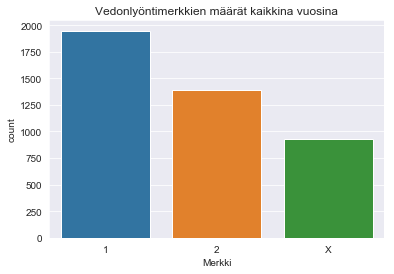

In [271]:
sns.countplot(x='Merkki',data=df)
plt.title('Vedonlyöntimerkkien määrät kaikkina vuosina')

Tarkastellaan seuraavaksi pelejä, joissa toinen joukkue (tai molemmat) on pelannut edellisenä päivänä 
ja toinen joukkue on lähtenyt peliin levänneen

Text(0.5,1,'Kotijoukkue levännyt, vieras pelannut päivää aiemmin')

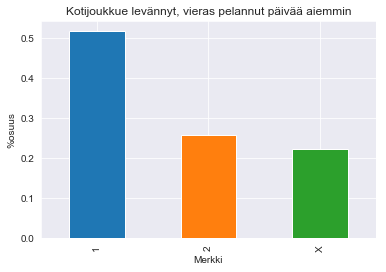

In [372]:
#Kotijoukkue levännyt, vierasjoukkue pelannut edellisenä päivänä
#Pelejä 436 kpl kymmenen vuoden aikana

df[(df.Koti_pelasi_eilen == 0) & (df.Vieras_pelasi_eilen == 1)].Merkki.value_counts(normalize=True).plot(kind='bar').set(xlabel='Merkki', ylabel='%osuus')
plt.title('Kotijoukkue levännyt, vieras pelannut päivää aiemmin')


Text(0.5,1,'Vierasjoukkue levännyt, kotijoukkue pelannut päivää aiemmin')

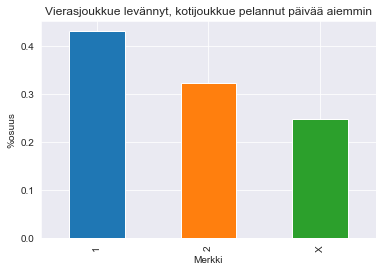

In [373]:
#Vierasjoukkue levännyt, kotijoukkue pelannut päivää aiemmin
#Pelejä vain 202 kpl viimeisen kymmenen vuoden aikana
df[(df.Koti_pelasi_eilen == 1) & (df.Vieras_pelasi_eilen == 0)].Merkki.value_counts(normalize=True).plot(kind='bar').set(xlabel='Merkki', ylabel='%osuus')
plt.title('Vierasjoukkue levännyt, kotijoukkue pelannut päivää aiemmin')

Text(0.5,1,'Molemmat joukkueet pelanneet päivää aiemmin')

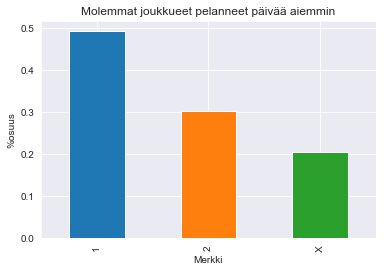

In [374]:
#Molemmat pelanneet edellisenä päivänä
#Pelejä yhteensä 376 kpl kymmenen vuoden aikana
df[(df.Koti_pelasi_eilen == 1) & (df.Vieras_pelasi_eilen == 1)].Merkki.value_counts(normalize=True).plot(kind='bar').set(xlabel='Merkki', ylabel='%osuus')
plt.title('Molemmat joukkueet pelanneet päivää aiemmin')

Tulosveto What if: Tarkastellaan seuraavaksi tulosvetoa, eli vetomuotoa, jossa tulee arvata pelin oikea tulos. Katsotaan miten olisi käynyt, jos olisimme lyöneet vetoa jokaisesta pelistä käyttämällä x-kappaletta (head(x)) yleisintä tulosta jokaiseen peliin.Keskikertoimen avulla voidaan testata sitä, mikä olisi pitänyt olla kertoimien keskiarvo, jotta vedot olisivat olleet tuottavia kausien ajan.

In [213]:
vedot = df.Peliaikatulos.value_counts().head(3).index.values
kertymä = []
panos = 0.5
keskikerroin = 15.1

for i in range(0,4262):

    #Tuloksen osuessa vetoihin, (panos*kerroin) miinus (panos*hävinneiden vetojen määrä)
    if df.Peliaikatulos[i] in vedot:
        kertymä.append((panos*keskikerroin)-(((len(vedot)-1)*panos)))
    
    #Mikäli oikea lopputulos ei vetojen joukossa, (panos*vetojen määrä) miinusta
    else:
        kertymä.append(len(vedot)*panos*(-1))

sum(kertymä)

22.850000000005387

In [206]:
#Tässä voi testata, mitä tuloksia yllä olevaan simulaattoriin menee head(x) eri arvoilla
df.Peliaikatulos.value_counts().head(3).index.values

array(['2-2', '3-2', '1-1'], dtype=object)